In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
using CSV,DataFrames;
import NLsolve,Roots;
pyplot(frame=:box,size=(500,350));

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

xsqrt (generic function with 1 method)

# VGT

In [4]:
qon_0(E)=xsqrt(2*μf(mDn,mDn)*(E-mDn-mDn))
qon_c(E)=xsqrt(2*μf(mDc,mDc)*(E-mDc-mDc))

qon_c (generic function with 1 method)

In [5]:
xxx,www=gauss(50,0,1);

In [6]:
qi=zeros(ComplexF64,length(xxx)+2);
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [7]:
function find_qw(E,Λ;rs=1,qi=qi,wi=wi)
    qi[1],qi[2]=qon_0(E)*(-1)^(rs+1),qon_c(E)
    for i in eachindex(xxx)
        qi[i+2]=Λ*xxx[i]
        wi[i]=Λ*www[i]
    end
    nothing
end

find_qw (generic function with 1 method)

In [8]:
Vmat=zeros(ComplexF64,2*sublen,2*sublen);
Gmat=zeros(ComplexF64,2*sublen,2*sublen);
Tmat=zeros(ComplexF64,2*sublen,2*sublen);

In [9]:
function VMat!(E;rs=1,Λ=0.5,plist=qi,des=Vmat)
    find_qw(E,Λ;rs=rs)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i,j=0,0
            des[i*sublen+l, j*sublen+m] = potential_DDbarn(E,plist[l], plist[m])
            i,j=0,1
            des[i*sublen+l, j*sublen+m] = potential_DDbarcross(E,plist[l], plist[m])
            i,j=1,0
            des[i*sublen+l, j*sublen+m] = potential_DDbarcross(E,plist[l], plist[m])
            i,j=1,1
            des[i*sublen+l, j*sublen+m] = potential_DDbarc(E,plist[l], plist[m])
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [10]:
Gn(E,q)=1/(2π^2)/(E-mDn-mDn-q^2/(2*μf(mDn,mDn)))
Gc(E,q)=1/(2π^2)/(E-mDc-mDc-q^2/(2*μf(mDc,mDc)))

Gc (generic function with 1 method)

In [11]:
function GMat!(E;rs=1,Λ=0.5,qi=qi,wi=wi,des=Gmat)
    find_qw(E,Λ;rs=rs)
    μ1,μ2=μf(mDn,mDn),μf(mDc,mDc)
    k1,k2=qi[1],qi[2]
    
    tmp=zero(ComplexF64)
    
    for j in eachindex(wi)
        des[2+j,2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
        tmp+=-wi[j]*k1^2*Gn(E,qi[2+j])
    end
    des[1,1]=tmp+μ1*k1/(2π^2)*(log((Λ+k1)/(Λ-k1))-im*π)
    
    tmp=0.0+0.0im
    for j in eachindex(wi)
        des[sublen+2+j,sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
        tmp+=-wi[j]*k2^2*Gc(E,qi[2+j])
    end
    des[2+sublen,2+sublen]=tmp+μ2*k2/(2π^2)*(log((Λ+k2)/(Λ-k2))-im*π)
    
    return nothing
end

GMat! (generic function with 1 method)

In [12]:
function detVG(E;rs=1,Λ=0.5)
    VMat!(E;rs=rs,Λ=Λ)
    GMat!(E;rs=rs,Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [13]:
function TMat!(E;rs=1,Λ=0.5,des=Tmat)
    VMat!(E;rs=rs,Λ=Λ)
    GMat!(E;rs=rs,Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

# Parameter study

In [14]:
function find_poles(pars)
    _rs,_lam=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,rs = _rs)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDn - 1e-3, 0.0])
    return tmp.residual_norm <1e-8 ? (tmp.zero[1]-mDn-mDn)+im*tmp.zero[2] : NaN+im*NaN
end

find_poles (generic function with 1 method)

In [18]:
find_poles([1,0.35])

-0.0002951132084145769 - 4.733390109663075e-20im

In [15]:
find_poles([1,0.4])

-0.002318438538596368 + 4.033258011958369e-20im

In [15]:
find_poles([1,0.55])

-0.01748696919977588 + 1.6015009005021375e-18im

In [23]:
find_poles([1,0.7])

-0.04322924870675138 + 1.863443692484591e-17im

In [17]:
detVG(mDn+mDn-0.002318438538596368 + 4.033258011958369e-20im;rs=1,Λ=0.4)

-6.638735498285477e-12 + 1.9175348317749362e-17im

In [18]:
let
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    det(LinearAlgebra.I-v11*g11-v12*g22)
end

-0.00869215590294646 + 1.9449301146603262e-17im

In [18]:
let
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    det(LinearAlgebra.I-v11*g11+v12*g22)
end

0.7592287349674851 - 2.609732084446329e-17im

## poles

In [19]:
Λv=collect(0.3:0.05:1.2);

In [20]:
poles_rs1=[find_poles([1,λ]) for λ in Λv];
poles_rs2=[find_poles([2,λ]) for λ in Λv];

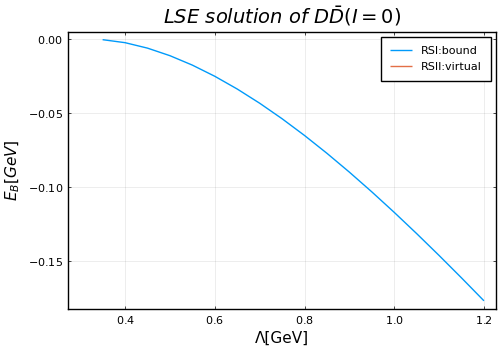

In [21]:
plot(xlabel="Λ[GeV]",ylabel=L"E_B[GeV]",title=L"LSE\ solution\ of\ D\bar{D}(I=0)")
plot!(Λv,real.(poles_rs1),label="RSI:bound")
plot!(Λv,real.(poles_rs2),label="RSII:virtual")

# Parameters from $T_{cc}^+$

In [18]:
df_tcc_cv=DataFrame(CSV.File("./output/df_cv.csv", header = ["Λ", "cv","cp","chi2","δΛ"]))

Row,Λ,cv,cp,chi2,δΛ
,Float64,Float64,Float64,Float64,Float64
1,0.396144,0.0,0.0,14.6907,0.0010708
2,0.406574,0.05,0.0,14.7925,9.35406e-6
3,0.418013,0.1,0.0,14.8565,0.00106976
4,0.427908,0.15,0.0,16.0446,0.00091588
5,0.443976,0.2,0.0,14.967,0.00103724
6,0.458998,0.25,0.0,15.0305,3.87699e-5
7,0.475823,0.3,0.0,15.0499,0.00108523
8,0.491791,0.35,0.0,16.1788,0.00103412
9,0.513466,0.4,0.0,16.2047,0.00128803


In [19]:
poles_rs1=[]

Any[]

In [21]:
for i in 1:16
    push!(poles_rs1,find_poles([1,df_tcc_cv.Λ[i]]))
end

In [22]:
poles_rs1

32-element Vector{Any}:
 -0.002099350779234843 - 3.979229904549488e-20im
 -0.002714578764483555 + 3.1568450679604396e-19im
  -0.00346996292372026 - 5.44064775962091e-19im
 -0.004188992080810916 + 1.2915017638987446e-18im
 -0.005481181024835635 - 2.3544796280717063e-19im
 -0.006823469779182911 - 9.46948445028562e-19im
 -0.008474819258636579 + 8.807818559918033e-20im
 -0.010181416563668666 - 6.033749652281689e-19im
 -0.012707401835470922 + 1.5702536734443146e-18im
  -0.01598156171190812 + 2.402993602134794e-18im
 -0.020975173108729095 + 1.502259167247342e-18im
  -0.02649028636299322 - 3.408989967694543e-18im
  -0.03583773194599038 - 2.8405222341310983e-18im
                       ⋮
 -0.005481181024835635 - 2.3544796280717063e-19im
 -0.006823469779182911 - 9.46948445028562e-19im
 -0.008474819258636579 + 8.807818559918033e-20im
 -0.010181416563668666 - 6.033749652281689e-19im
 -0.012707401835470922 + 1.5702536734443146e-18im
  -0.01598156171190812 + 2.402993602134794e-18im
 -0.020975173108